Get distribution of dihedral angles between units 

In [1]:
# Standard 
import os, sys , copy ,shutil, logging, csv, json, logging
logger = logging.getLogger()
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from scipy import optimize
from scipy import stats
from streamm import values

# Import all the streamm modules
from streamm import *

%load_ext autoreload
%autoreload 2

In [2]:
from dask import delayed


In [3]:
local = resource.Resource('local')
local.load_json()

peregrine = resource.Resource('peregrine')
peregrine.load_json()

Reading in resource json file res_local.json 
Reading in resource json file res_peregrine.json 


In [4]:
print local.dir['home']

/Users/tkemper/Projects/DApolymers


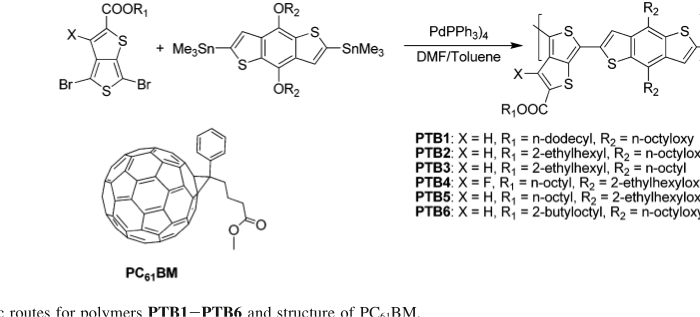

In [5]:
from IPython.display import Image
Image(filename=local.dir['home']+'/figures/PTBX.png')

In [6]:
os.getcwd()

'/Users/tkemper/Projects/DApolymers/notebooks'

In [7]:
proj_ref = 'res_et2'
proj_ref = project.Project('DAPpolymers_%s'%(proj_ref))
proj_ref.load_json()

Resource tag found peregrine 
Reading in resource json file res_peregrine.json 
Resource tag found peregrine 
Reading in resource json file res_peregrine.json 
Resource tag found peregrine 
Reading in resource json file res_peregrine.json 
Resource tag found peregrine 
Reading in resource json file res_peregrine.json 
Resource tag found peregrine 
Reading in resource json file res_peregrine.json 
Resource tag found peregrine 
Reading in resource json file res_peregrine.json 
Resource tag found peregrine 
Reading in resource json file res_peregrine.json 
Resource tag found peregrine 
Reading in resource json file res_peregrine.json 
Resource tag found peregrine 
Reading in resource json file res_peregrine.json 


In [9]:
proj_suf = "DihDist"
proj_i = project.Project("DAPpolymers_%s"%(proj_suf))
proj_i.load_json()

In [ ]:
c_cnt = 0
for ckey,sim_prod1 in proj_ref.calculations.iteritems():
    print c_cnt,sim_prod1.tag,sim_prod1.meta['status']
    c_cnt += 1     

In [10]:
proj_ref.calculations['D1_R2R200_A2_R3_R200R200R201_n5_x197_prod1_min2_grp1_remin1_res_et2'].meta['status'] = 'process'
proj_ref.calculations['D1_R2R200_A23_R4_n1_R41n1R41n1R41n1__n5_x193_prod1_min2_grp1_remin1_res_et2'].meta['status'] = 'process'
proj_ref.calculations['D1_R2R200_A23_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2'].meta['status'] = 'process'
proj_ref.calculations['D1_R2R200_A31_R4_n1_R40n1R40n1R42n1__n5_x173_prod1_min2_grp1_remin1_res_et2'].meta['status'] = 'process'
proj_ref.calculations['D1_R2R200_A31_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2'].meta['status'] = 'process'
proj_ref.calculations['D51_00R300R3_A23_R4__n1wB_R41n1wBR41n1wBR41n1wB__n5_x173_prod1_min2_grp1_remin1_res_et2'].meta['status'] = 'process'

In [ ]:
refcalc_i =  proj_ref.calculations['D1_R2R200_A31_R4_n1_R40n1R40n1R42n1__n5_x173_prod1_min2_grp1_remin1_res_et2']

In [ ]:
print refcalc_i.properties['name']

In [ ]:
def pull_all(refcalc_i):
    refcalc_i.set_resource(peregrine)

    comp_key = refcalc_i.properties['comp_key']
    
    refcalc_i.files['input'][comp_key] = '%s_input.tgz'%(refcalc_i.tag)
    refcalc_i.files['output'][comp_key] = '%s_output.tgz'%(refcalc_i.tag)
    refcalc_i.files['data'][comp_key] = '%s_data.tgz'%(refcalc_i.tag)

    os.chdir(refcalc_i.dir['launch'])

    os.getcwd()

    print refcalc_i.meta['status']

    refcalc_i.pull(file_type_list=['output','data','input'])

In [ ]:
for ckey,refcalc_i in proj_ref.calculations.iteritems():
    if( refcalc_i.meta['status'] == 'stored' ):
        pull_all(refcalc_i)

In [ ]:
def find_resgroups(refcalc_i):
    os.chdir(refcalc_i.dir['launch'])
    os.getcwd()

    lfile = open("DA.list",'rb')
    t_i = lfile.readlines()
    lfile.close()
    list_i = [int(pkey) for pkey in  t_i]


    struc_i = buildingblock.Container(refcalc_i.tag)
    struc_i.read_cply()
    print struc_i.n_particles

    struc_i.group_prop('residue','residue',particles_select=list_i)
    groupset_i = struc_i.groupsets['residue']
    for gkey,group_i in groupset_i.groups.iteritems():
        for pkey in group_i.pkeys:
            struc_i.particles[pkey].properties['group'] = gkey
            
    refcalc_i.strucC = struc_i

In [ ]:
for ckey,refcalc_i in proj_ref.calculations.iteritems():
    if( refcalc_i.meta['status'] == 'stored' ):
        find_resgroups(refcalc_i)
        print "Tag %s had %d particles "%(refcalc_i.tag,refcalc_i.strucC.n_particles)

In [ ]:
for ckey,refcalc_i in proj_ref.calculations.iteritems():
    if( refcalc_i.meta['status'] == 'stored' ):
        print "Tag %s had %d particles "%(refcalc_i.tag,refcalc_i.strucC.n_particles)

In [ ]:
def calc_dihdist(struc_i):
    struc_i = refcalc_i.strucC
    os.chdir(refcalc_i.dir['launch'])
    os.getcwd()
    
    print "Processing %s"%(struc_i.tag)

    struc_i.bonded_dih()

    struc_i.propcompile_particles()
    struc_i.pd_df =  pd.DataFrame(struc_i.prop_particles)
    struc_i.pd_df.columns


    sub_i =  struc_i.pd_df[struc_i.pd_df['fftype'] == 'C!']
    sub_j =  struc_i.pd_df[struc_i.pd_df['fftype'] == 'C!']
    sub_k =  struc_i.pd_df[struc_i.pd_df['fftype'] == 'CS']
    #sub_k =  struc_i.pd_df[ (struc_i.pd_df['fftype'] == 'CS') & (struc_i.pd_df['resname'] == 'D1') ]

    sub_l =  struc_i.pd_df[struc_i.pd_df['fftype'] == 'CB']

    print len(sub_i.index),len(sub_j.index),len(sub_l.index),len(sub_k.index)
    dih_keys = struc_i.find_dihedrals(list_k=sub_k.index,list_i=sub_i.index,list_j=sub_j.index,list_l=sub_l.index)
    print len(dih_keys)/9
    struc_i.calc_dihedrals(keys=dih_keys)
    struc_i.write_dihedrals('dih_CCCC.csv',keys=dih_keys)
    struc_i.write_xyz()


In [ ]:
refcalc_i = proj_ref.calculations['D51_00R300R3_A23_R4__n1wB_R41n1wBR41n1wBR41n1wB__n5_x173_prod1_min2_grp1_remin1_res_et2']

In [ ]:
calc_dihdist(refcalc_i.strucC)

In [ ]:
for ckey,refcalc_i in proj_ref.calculations.iteritems():
    if( refcalc_i.meta['status'] == 'stored' ):
        calc_dihdist(refcalc_i.strucC)
        print " finished ",refcalc_i.tag

In [11]:
def calc_dihdist(refcalc_i):
    os.chdir(refcalc_i.dir['launch'])
    return pd.read_csv('dih_CCCC.csv')

In [21]:
for ckey,refcalc_i in proj_ref.calculations.iteritems():
    if( refcalc_i.meta['status'] == 'process' ):

        calc_i = calculation.CalculationRes('%s_%s'%(ckey,proj_suf))
        calc_i.set_resource(local)
        calc_i.properties['name'] = refcalc_i.properties['name']
        calc_i.dihdists = calc_dihdist(refcalc_i)
        
        
        proj_i.calculations[calc_i.tag] = copy.deepcopy(calc_i)
        

In [33]:

for ckey,calc_i in proj_i.calculations.iteritems():
        print calc_i.tag,calc_i.properties['name']

D1_R2R200_A31_R4_n1_R40n1R40n1R42n1__n5_x173_prod1_min2_grp1_remin1_res_et2_DihDist PTB1
D1_R2R200_A31_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2_DihDist PTB5
D51_00R300R3_A23_R4__n1wB_R41n1wBR41n1wBR41n1wB__n5_x173_prod1_min2_grp1_remin1_res_et2_DihDist PCE10
D1_R2R200_A2_R3_R200R200R201_n5_x197_prod1_min2_grp1_remin1_res_et2_DihDist BDT-TPD
D1_R2R200_A23_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2_DihDist PTB4
D1_R2R200_A23_R4_n1_R41n1R41n1R41n1__n5_x193_prod1_min2_grp1_remin1_res_et2_DihDist PTB7


In [36]:
name_l = []
name_l.append('BDT-TPD')
name_l.append('PTB1')
name_l.append('PTB5')
name_l.append('PTB4')
name_l.append('PTB7')
name_l.append('PCE10')

In [23]:
for ckey,calc_i in proj_i.calculations.iteritems():
    calc_i.dir['materials'] = "/Users/tkemper/Projects/DApolymers/materials/%s"%(calc_i.properties['name'])

In [27]:
for ckey,calc_i in proj_i.calculations.iteritems():
    os.chdir(calc_i.dir['materials'])
    calc_i.dihdists.to_csv('dih_CCCC.csv', sep=',', encoding='utf-8')


In [29]:
os.chdir('/Users/tkemper/Projects/DApolymers/figures')

In [32]:
for ckey,calc_i in proj_i.calculations.iteritems():
    val_i = values.Values('cosine',calc_i.dihdists['cosine'].abs())
    #val_i = values.Values('cosine',dih_df['cosine'].apply(lambda x: np.rad2deg(np.arccos(abs(x)))))
    val_i.calc_stats()
    val_i.set_bins(.05)
    val_i.calc_hist()
    calc_i.dih_vals = copy.deepcopy(val_i)
    #

BDT-TPD
PTB1
PTB5
PTB4
PTB7
PCE10


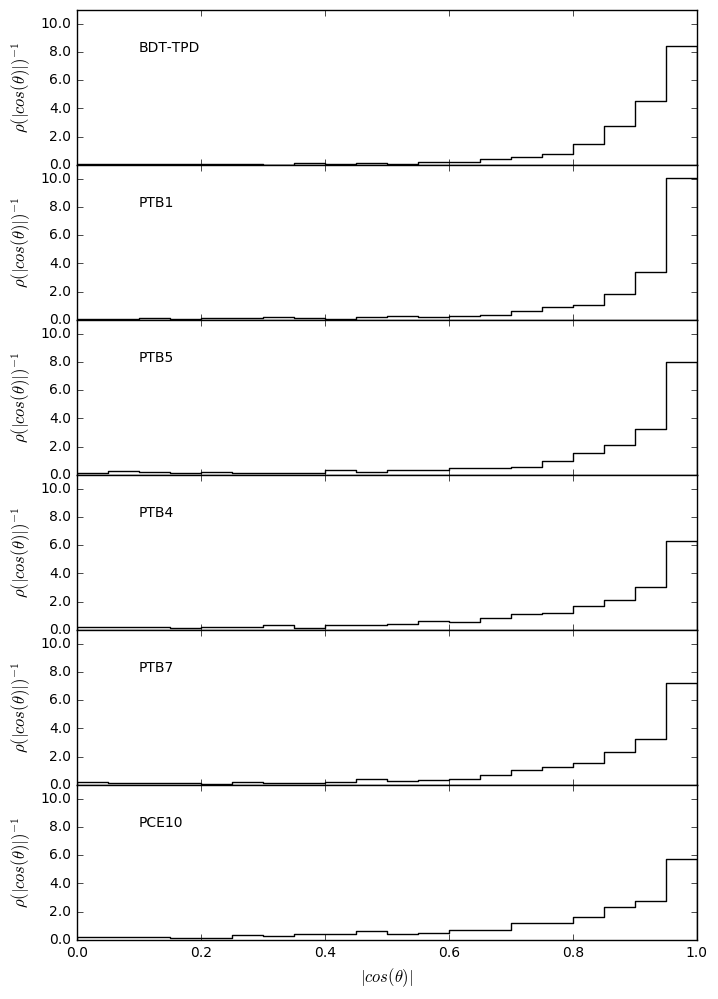

In [41]:
fig, ax = plt.subplots(6,sharex=True)
#ax.plot(rgy_sq_vals.bin_val,rgy_sq_vals.hist_bin)
#ax.bar(rgy_sq_vals.bins_cent, rgy_sq_vals.hist_cent , align='center', width=rgy_sq_vals.bin_size)
i = 0
for name_i in name_l:
    for tag_i,calc_o in proj_i.calculations.iteritems():
        if( calc_o.properties['name'] == name_i ):
            calc_i = calc_o
    print calc_i.properties['name']
    val_i = calc_i.dih_vals
    #fig, ax = plt.subplots(1)
    ax[i].plot(val_i.bins_steps,val_i.hist_steps,'k-',ls = "steps")
    #ax[i].set_xlabel(r'$R^2$ ($\AA^2$)',fontsize=12)
    #ax[i].set_xlabel(r'$l^2$ ($\AA^2$)',fontsize=12)
    ax[i].set_ylabel(r'$\rho (|cos(\theta)|)^{-1}$',fontsize=12)
    ax[i].set_xlabel(r'$|cos(\theta)|$',fontsize=12)
    ax[i].set_xlim(0,1.0)
    ax[i].set_ylim(0.0,11.0)
    #ax[i].text(55,0.015,name_i)
    #ax[i].set_xlim(0,1.0)
    #ax[i].set_ylim(0.0,6.0)
    ax[i].text(0.1,8.0,name_i)

    labels=ax[i].get_yticks().tolist()
    labels[-1]=''
    ax[i].set_yticklabels(labels)    

    
    i+=1
#i += -1

fig.subplots_adjust(hspace=0.0)   
fig.set_size_inches(8.0, 12.0)

fig.savefig("%s_hist.pdf"%('cosine_theta'),format='pdf')

In [48]:
for ckey,calc_i in proj_i.calculations.iteritems():
    val_i = values.Values('cosine',calc_i.dihdists['cosine'].apply(lambda x: np.rad2deg(np.arccos(abs(x)))))

    val_i.calc_stats()
    val_i.set_bins(5.0)
    val_i.calc_hist()
    calc_i.dihdeg_vals = copy.deepcopy(val_i)



BDT-TPD
PTB1
PTB5
PTB4
PTB7
PCE10


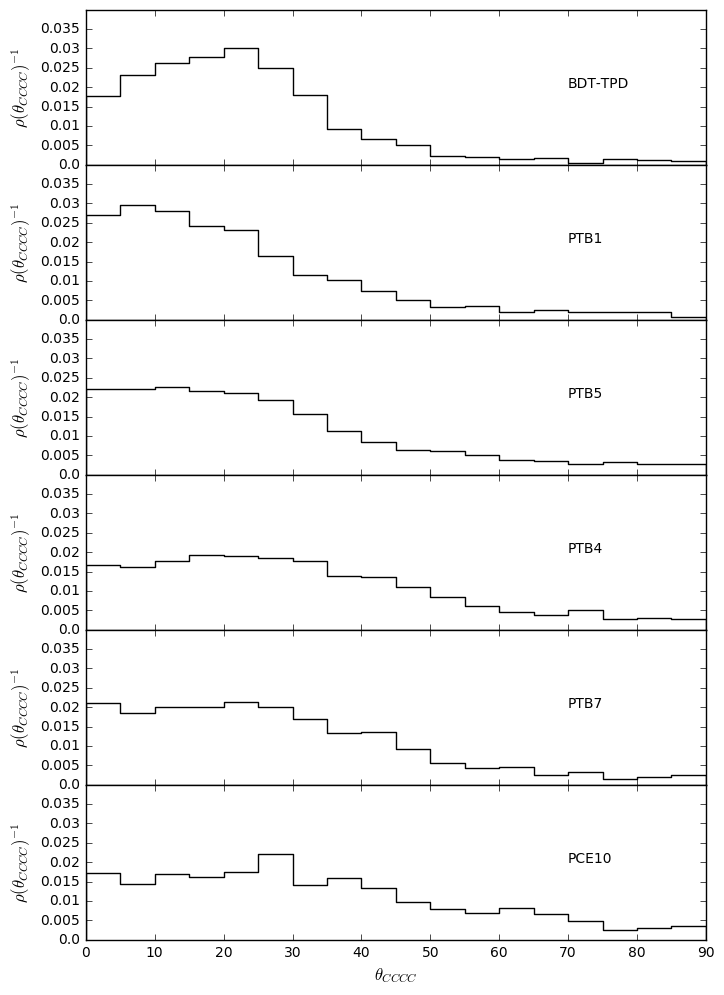

In [50]:
fig, ax = plt.subplots(6,sharex=True)
#ax.plot(rgy_sq_vals.bin_val,rgy_sq_vals.hist_bin)
#ax.bar(rgy_sq_vals.bins_cent, rgy_sq_vals.hist_cent , align='center', width=rgy_sq_vals.bin_size)
i = 0
for name_i in name_l:
    for tag_i,calc_o in proj_i.calculations.iteritems():
        if( calc_o.properties['name'] == name_i ):
            calc_i = calc_o
    print calc_i.properties['name']
    val_i = calc_i.dihdeg_vals
    #fig, ax = plt.subplots(1)
    ax[i].plot(val_i.bins_steps,val_i.hist_steps,'k-',ls = "steps")
    #ax[i].set_xlabel(r'$R^2$ ($\AA^2$)',fontsize=12)
    #ax[i].set_xlabel(r'$l^2$ ($\AA^2$)',fontsize=12)
    ax[i].set_ylabel(r'$\rho (\theta_{CCCC})^{-1}$',fontsize=12)
    ax[i].set_xlabel(r'$\theta_{CCCC}$',fontsize=12)
    ax[i].set_xlim(0.0,90.0)
    ax[i].set_ylim(0.0,0.040)
    #ax[i].text(55,0.015,name_i)
    #ax[i].set_xlim(0,1.0)
    #ax[i].set_ylim(0.0,6.0)
    ax[i].text(70.0,0.02,name_i)

    labels=ax[i].get_yticks().tolist()
    labels[-2]=''
    ax[i].set_yticklabels(labels)    
    
    i+=1
#i += -1

fig.subplots_adjust(hspace=0.0)   
fig.set_size_inches(8.0, 12.0)

fig.savefig("%s_hist.pdf"%('dih_theta'),format='pdf')


In [54]:
table_str = "Name & \\bar{$\\theta_{CCCC}$} (deg) & \\sigma($\\theta_{CCCC}$) \\hline \n"
for name_i in name_l:
    for tag_i,calc_o in proj_i.calculations.iteritems():
        if( calc_o.properties['name'] == name_i ):
            calc_i = calc_o
    print calc_i.properties['name']
    val_i = calc_i.dihdeg_vals
    table_str += "%s & %6.2f & %6.2f \\\\ \n"%(name_i,val_i.mean,val_i.std)

BDT-TPD
PTB1
PTB5
PTB4
PTB7
PCE10


In [55]:
print table_str

Name & \bar{$\theta_{CCCC}$} (deg) & \sigma($\theta_{CCCC}$) \hline 
BDT-TPD &  22.96 &  15.69 \\ 
PTB1 &  22.48 &  18.27 \\ 
PTB5 &  27.36 &  20.87 \\ 
PTB4 &  31.29 &  21.10 \\ 
PTB7 &  28.01 &  19.78 \\ 
PCE10 &  32.83 &  21.74 \\ 



In [56]:
os.chdir('/Users/tkemper/Projects/DApolymers/tables/')

In [57]:
f = open('dih_theta.tex','w')
f.write(table_str)
f.close()